# Test Script for Airbnb project - Using data from 09 November, 2019

**Author**: Álvaro Ortiz (ortiz.fernandez.alvaro@gmail.com)<br>
**Date**: 2019-12-21

This is not the main notebook for this project. This notebook is intended to serve as a playground for me, a place where I can test new ideas and write code as I go. To take a look at the actual project and its findings, please head to 
**airbnb_main.ipynb**

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json


%matplotlib notebook

In [207]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import geojsonio

### Load the Data from [Inside Airbnb](http://insideairbnb.com/) related to Airbnb housing market in Barcelona

In [205]:
listings = pd.read_csv('./listings_summary_2019.csv')
listings_all = pd.read_csv('./listings.csv')
calendar = pd.read_csv('./calendar.csv')
reviews = pd.read_csv('./reviews.csv')
neighbourhoods = pd.read_csv('./neighbourhoods.csv')

C:\Users\alvaroof89\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [208]:
print(listings.shape)
print(calendar.shape)
print(listings_all.shape)
print(reviews.shape)
print(neighbourhoods.shape)

(20428, 16)
(7456220, 7)
(20428, 106)
(740992, 6)
(73, 2)


In [209]:
gpd_barcelona = gpd.read_file('./neighbourhoods.geojson')
json_barcelona = gpd_barcelona.to_json()

### Load data from [Barcelona's Open Data Portal](https://opendata-ajuntament.barcelona.cat/en/) related to standard housing market (only rentings)

In [210]:
cont = pd.DataFrame() # this list contains csv counting number of rented homes in Barcelona for the given period
preu = pd.DataFrame() # this list contains csv with the mean price of rented homes in Barcelona for the given period

for i,file in enumerate(os.listdir('./')):
    if 'lloguer_cont' in file:
        file = os.path.basename(file)
        file = './' + file
        cont = pd.concat([cont,pd.read_csv(file)])
    elif 'lloguer_preu' in file:
        file = os.path.basename(file)
        file = './' + file
        preu = pd.concat([preu,pd.read_csv(file)])
        
preu = preu.loc[preu['Lloguer_mitja']=='Lloguer mitjà mensual (Euros/mes)'].drop(columns=['Lloguer_mitja'])
cont = cont.drop(columns=['Contractes'])

cols_to_join = preu.columns[preu.columns != 'Preu'].tolist()

housing_info_barcelona = preu.merge(cont, left_on=cols_to_join, right_on=cols_to_join)

In [211]:
listings.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18666,Flat with Sunny Terrace,71615,Mireia And Maria,Sant Martí,el Camp de l'Arpa del Clot,41.40889,2.18555,Entire home/apt,130,3,1,2015-10-10,0.02,30,304
1,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40420,2.17306,Entire home/apt,60,1,20,2019-10-19,0.25,30,312


In [212]:
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,18666,2019-11-09,f,$130.00,$130.00,3,730
1,18666,2019-11-10,f,$130.00,$130.00,3,730


In [11]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,Ciutat Vella,el Barri Gòtic
1,Ciutat Vella,el Raval
2,Ciutat Vella,la Barceloneta
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
4,Eixample,el Fort Pienc


In [12]:
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,18666,50158511,2015-10-10,1559265,Jody,Very nice flat. We had easy transportation to ...
1,18674,4808211,2013-05-27,4841196,Caron,"Great location. Clean, spacious flat. Would re..."


### are the neighbourhoods listed in BCN open data portal and in Airbnb named the same?

In [126]:
bcn_districts = set(housing_info_barcelona['Nom_Districte'].unique())

In [127]:
airbnb_districs = set(listings['neighbourhood_group'].unique())

In [131]:
bcn_districts.difference(airbnb_districs)

set()

In [132]:
bcn_neighbourhoods = set(housing_info_barcelona['Nom_Barri'].unique())

In [133]:
airbnb_neighbourhoods = set(listings['neighbourhood'].unique())

In [137]:
if len(bcn_neighbourhoods) > len(airbnb_neighbourhoods):
    print(bcn_neighbourhoods.difference(airbnb_neighbourhoods))
elif len(bcn_neighbourhoods) < len(airbnb_neighbourhoods):
    print(airbnb_neighbourhoods.difference(bcn_neighbourhoods))

{'la Clota', 'Vallbona'}


Seem that the neighbourhood are correctly mapped in the airbnb data and therefore a comparison with the data provided in the open bcn website can be made.

## Handle categorical and missing data

In [218]:
listings.isna().sum()

id                                   0
name                                15
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       4276
reviews_per_month                 4276
calculated_host_listings_count       0
availability_365                     0
dtype: int64

# Possible Questions

# 1. Airbnb claims that it only enables people to share housing they live in, not monetizing it like a business. How many hosts have more than one listing, and therefore, are likely to be managing their listings business-like?

### Let's start by examining how many hosts there are, and how many listings they have

We define active listings as those that have only been rented recently (reviewed in the last 6 months), and are being rented regularly (number of nights per year greater than the threshold for that city). Some reviews may be "spam" allowed by Airbnb. Analysis suggests that spam reviews are small and do not affect the statistics.

In [217]:
listings['room_type']

0        Entire home/apt
1        Entire home/apt
2        Entire home/apt
3           Private room
4        Entire home/apt
              ...       
20423    Entire home/apt
20424    Entire home/apt
20425    Entire home/apt
20426    Entire home/apt
20427       Private room
Name: room_type, Length: 20428, dtype: object

In [59]:
# Calculate number of different hosts
no_active_hosts = listings['host_id'].nunique()
no_active_listings = listings.shape[0]

In [37]:
print('There are {} different hosts in Barcelona at the time of the snapshot. 09 November, 2019'.format(no_active_hosts))

There are 10086 different hosts in Barcelona at the time of the snapshot. 09 November, 2019


In [33]:
# listings.drop_duplicates(subset=['host_id','id']).shape

In [78]:
# listings[['host_id','id']].drop_duplicates().groupby('host_id').size().hist(bins=100);

In [79]:
number_listing_per_host = listings.groupby('host_id').size().sort_values(ascending=False)
number_listing_per_host.head(10)

host_id
102947901    155
170716140    154
4459553      140
158023606    128
171236207    114
193618270    104
396363        99
36607755      98
1447144       90
1391607       88
dtype: int64

### What percentage of listings he top 5% hosts own?

In [53]:
perc5 = int(np.floor(no_active_hosts*0.05))
perc5_host = number_listing_per_host.index[0:perc5]
perc5_listings = number_listing_per_host.iloc[0:perc5].sum()

In [77]:
100*perc5_listings/no_active_listings
print('The top 5% most wealthy hosts own an anything but ridiculous {:2.2f}% of the total listings'.format(100*perc5_listings/no_active_listings))

The top 5% most wealthy hosts own an anything but ridiculous 35.45% of the total listings


### How many hosts have more than 1 listing?

In [74]:
hosts_more_than_one_listing = (number_listing_per_host > 1).sum()
print('The percentage of hosts that own more than one active listing is {:2.2f}%'.format(100*hosts_more_than_one_listing/no_active_hosts))

The percentage of hosts that own more than one active listing is 29.21%


# 2. Which are the neighbourhoods that concentrate the hosts with the higher number of listings? This neighbourhoods can be an indicator of where airbnb is having a greater negative impact

### by neighbourhood_group

In [89]:
listings_per_neighbourhood_host = listings.groupby(['neighbourhood_group','host_id']).size()

In [90]:
# Only interested on those hosts with more than one listing
spl = (listings_per_neighbourhood_host > 1)
listings_per_neighbourhood_host = listings_per_neighbourhood_host[spl]
listings_per_neighbourhood_host

neighbourhood_group  host_id  
Ciutat Vella         10704         9
                     71615         2
                     73163         2
                     136853       10
                     224605        2
                                  ..
Sarrià-Sant Gervasi  280042827     2
                     283385188     2
                     298575589     3
                     299589921     3
                     301501550     4
Length: 3167, dtype: int64

In [100]:
listings_per_neighbourhood_illegal = listings_per_neighbourhood_host.groupby('neighbourhood_group').sum()
listings_per_neighbourhood_illegal

neighbourhood_group
Ciutat Vella           3008
Eixample               4622
Gràcia                  976
Horta-Guinardó          306
Les Corts               195
Nou Barris               98
Sant Andreu             151
Sant Martí             1218
Sants-Montjuïc         1341
Sarrià-Sant Gervasi     437
dtype: int64

In [101]:
listings_per_neighbourhood = listings.groupby('neighbourhood_group').size()
listings_per_neighbourhood

neighbourhood_group
Ciutat Vella           4943
Eixample               6719
Gràcia                 1771
Horta-Guinardó          674
Les Corts               421
Nou Barris              252
Sant Andreu             354
Sant Martí             2174
Sants-Montjuïc         2363
Sarrià-Sant Gervasi     757
dtype: int64

In [104]:
(listings_per_neighbourhood_illegal/listings_per_neighbourhood).sort_values(ascending=False)

neighbourhood_group
Eixample               0.687900
Ciutat Vella           0.608537
Sarrià-Sant Gervasi    0.577279
Sants-Montjuïc         0.567499
Sant Martí             0.560258
Gràcia                 0.551101
Les Corts              0.463183
Horta-Guinardó         0.454006
Sant Andreu            0.426554
Nou Barris             0.388889
dtype: float64

Unfortunately the clustering in neighbourhood_groups is not granular enough as to allow us to really see the differences in different parts of Barcelona. We will repeat the analysis by individual neighbourhood

### by neighbourhood

In [105]:
listings_per_neighbourhood_host = listings.groupby(['neighbourhood','host_id']).size()

In [106]:
# Only interested on those hosts with more than one listing
spl = (listings_per_neighbourhood_host > 1)
listings_per_neighbourhood_host = listings_per_neighbourhood_host[spl]
listings_per_neighbourhood_host

neighbourhood    host_id  
Can Baró         5107063      3
                 45260292     2
                 54320669     2
                 111554365    2
                 148901099    2
                             ..
les Roquetes     78774930     2
                 151668430    2
les Tres Torres  4459553      4
                 5843487      8
                 106269512    3
Length: 3222, dtype: int64

In [107]:
listings_per_neighbourhood_illegal = listings_per_neighbourhood_host.groupby('neighbourhood').sum()
listings_per_neighbourhood_illegal

neighbourhood
Can Baró                                         18
Ciutat Meridiana                                  2
Diagonal Mar i el Front Marítim del Poblenou    121
Horta                                            12
Hostafrancs                                     150
                                               ... 
la Vila Olímpica del Poblenou                    88
la Vila de Gràcia                               624
les Corts                                        99
les Roquetes                                     12
les Tres Torres                                  15
Length: 68, dtype: int64

In [108]:
listings_per_neighbourhood = listings.groupby('neighbourhood').size()
listings_per_neighbourhood

neighbourhood
Baró de Viver                       1
Can Baró                           43
Can Peguera                         2
Canyelles                           4
Ciutat Meridiana                    8
                                 ... 
la Vila Olímpica del Poblenou     185
la Vila de Gràcia                1122
les Corts                         228
les Roquetes                       30
les Tres Torres                    33
Length: 71, dtype: int64

In [112]:
(listings_per_neighbourhood_illegal/listings_per_neighbourhood).sort_values(ascending=False)

neighbourhood
la Dreta de l'Eixample                   0.743687
la Marina del Prat Vermell               0.642857
el Barri Gòtic                           0.635980
Sant Gervasi - Galvany                   0.631579
l'Antiga Esquerra de l'Eixample          0.630213
                                           ...   
la Guineueta                             0.142857
Vallvidrera, el Tibidabo i les Planes    0.057143
Baró de Viver                                 NaN
Can Peguera                                   NaN
Canyelles                                     NaN
Length: 71, dtype: float64

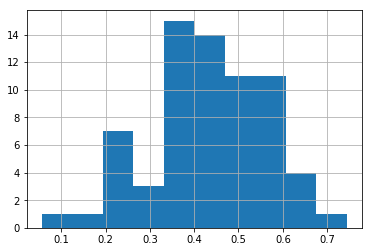

In [113]:
(listings_per_neighbourhood_illegal/listings_per_neighbourhood).sort_values(ascending=False).hist()

the histogram above tells a sad story. If everything went accordingly to what Airbnb says all the mass would be concentrated at 0, but as we can see, it is totally the opposite. Most of the neighbourhoods count with more than 20% of listings belonging to hosts that have more than one property listed on airbnb

# 3. Has the trend (increase/decrease of listings) in airbnb affected the number of renting contracts signed in Barcelona?

In [138]:
listings_2019 = pd.read_csv('./listings_summary_2019.csv')
listings_2018 = pd.read_csv('./listings_summary_2018.csv')
listings_2017 = pd.read_csv('./listings_summary_2017.csv')
listings_2016 = pd.read_csv('./listings_summary_2016.csv')
listings_2015 = pd.read_csv('./listings_summary_2015.csv')

In [190]:
active_listings_2019 = listings_2019.groupby('neighbourhood').size().reset_index()
active_listings_2019['year'] = 2019

active_listings_2018 = listings_2018.groupby('neighbourhood').size().reset_index()
active_listings_2018['year'] = 2018

active_listings_2017 = listings_2017.groupby('neighbourhood').size().reset_index()
active_listings_2017['year'] = 2017

active_listings_2016 = listings_2016.groupby('neighbourhood').size().reset_index()
active_listings_2016['year'] = 2016

active_listings_2015 = listings_2015.groupby('neighbourhood').size().reset_index()
active_listings_2015['year'] = 2015

In [192]:
df_active_listings = pd.concat([active_listings_2015,
                   active_listings_2016,
                   active_listings_2017,
                   active_listings_2018,
                   active_listings_2019])
df_active_listings = df_active_listings.rename(columns = {0:'active_listings'})

In [194]:
df_open_bcn = housing_info_barcelona.groupby(['Any','Nom_Barri']).sum()['Nombre']
df_open_bcn = pd.DataFrame(df_open_bcn).reset_index()
df_open_bcn = df_open_bcn.rename(columns={'Nom_Barri':'neighbourhood', 'Any':'year', 'Nombre':'contract_count'})

In [196]:
df_housing = df_open_bcn.merge(df_active_listings, left_on=['year','neighbourhood'], right_on=['year','neighbourhood'])

### Examples of neighbourhoods with more listings that signed contracts

In [203]:
spl = df_housing['active_listings'] > df_housing['contract_count']

In [204]:
df_housing[spl]

,year,neighbourhood,contract_count,active_listings
18,2015,"Sant Pere, Santa Caterina i la Ribera",1014.0,1111
28,2015,el Barri Gòtic,684.0,1091
66,2015,la Vila Olímpica del Poblenou,165.0,166
100,2016,el Barri Gòtic,785.0,1188
172,2017,el Barri Gòtic,808.0,1074
197,2017,la Marina del Prat Vermell,4.0,13
244,2018,el Barri Gòtic,967.0,1194
262,2018,la Barceloneta,415.0,419
269,2018,la Marina del Prat Vermell,3.0,11
